In [ ]:
!gdown 1HHDArB7q9DydXHGz0NWMxYnLufgC_AQf

Downloading...
From: https://drive.google.com/uc?id=1HHDArB7q9DydXHGz0NWMxYnLufgC_AQf
To: /content/Q1_data.zip
100% 259M/259M [00:04<00:00, 56.2MB/s]


In [ ]:
import zipfile
import os

rar_file_path = '/content/Q1_data.zip'
folder_path = '/content/Dataset'

with zipfile.ZipFile(rar_file_path, 'r') as zip_ref:
    zip_ref.extractall(folder_path)

data_path= '/content/Dataset/Water Bodies Dataset/'


In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage


image_path = "/content/Dataset/Water Bodies Dataset/Images/*.jpg"
mask_path = "/content/Dataset/Water Bodies Dataset/Masks/*.jpg"

def random_rotation(image, mask):
  if np.random.rand() > 0.5:
    angle = np.random.uniform(-30, 30)
    image = ndimage.rotate(image, angle, reshape=False)
    mask = ndimage.rotate(mask, angle, reshape=False)
  return image, mask

def horizontal_flip(image, mask):
    if np.random.rand() > 0.5:
        image = np.fliplr(image)
        mask = np.fliplr(mask)
    return image, mask

def vertical_flip(image, mask):
    if np.random.rand() > 0.5:
        image = np.flipud(image)
        mask = np.flipud(mask)
    return image, mask




image_paths = sorted(glob.glob(image_path), key=lambda x: x.split('.')[0])
mask_paths = sorted(glob.glob(mask_path), key=lambda x: x.split('.')[0])
image_list = []
mask_list = []
i=0
for image_path, mask_path in zip(image_paths, mask_paths):
    # Load the image and mask
    image1 = plt.imread(image_path).astype(np.float32) / 255.
    mask1 = plt.imread(mask_path).astype(np.float32) / 255.
    image1 = cv2.resize(image1, (128, 128))
    mask1 = cv2.resize(mask1, (128, 128))

    image_list.append(image1)
    mask_list.append(mask1)

    image, mask = random_rotation(image1, mask1)
    image_list.append(image)
    mask_list.append(mask)

    image, mask = horizontal_flip(image1, mask1)
    image_list.append(image)
    mask_list.append(mask)

    image, mask = vertical_flip(image1, mask1)
    image_list.append(image)
    mask_list.append(mask)

    # print(i)
    i= i+1

image_array = np.array(image_list)
mask_array = np.array(mask_list)

# Check the shapes of the resized image and mask arrays
print("Resized image array shape:", image_array.shape)
print("Resized mask array shape:", mask_array.shape)

Resized image array shape: (11364, 128, 128, 3)
Resized mask array shape: (11364, 128, 128, 3)


First image with augmentations:


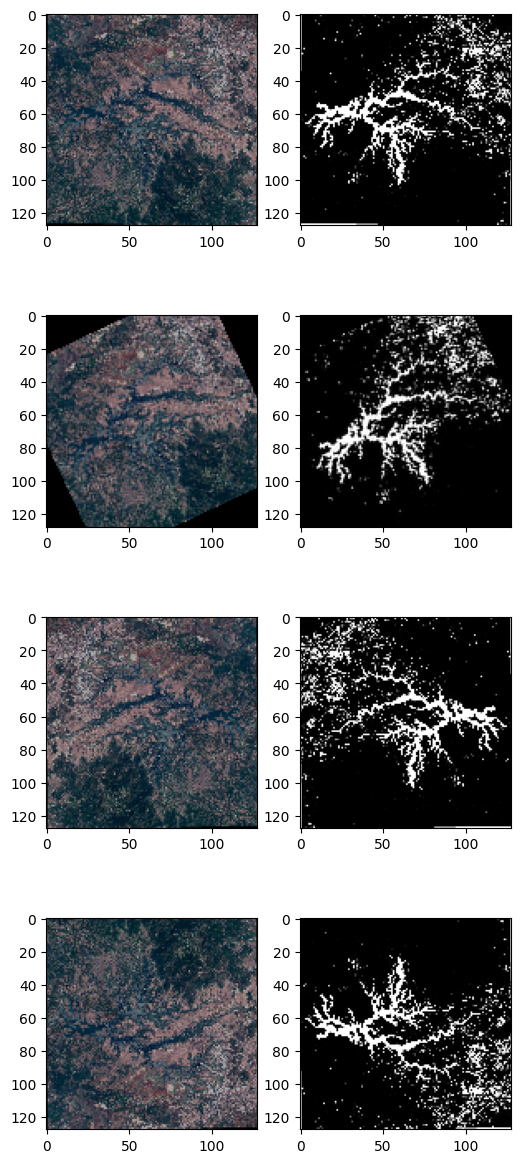

In [ ]:
def show_img(img1,img2, nrows=4, ncols=2, figsize=(6, 15)):
  fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
  print('First image with augmentations:')
  for i in range(nrows):
    ax[i][0].imshow(img1[i])
    ax[i][1].imshow(img2[i])


show_img(image_array, mask_array)

# Torch Method

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
from torchvision import transforms

Gray_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x * 255).astype(np.uint8)),  # Convert to uint8
    transforms.ToPILImage(),  # Convert NumPy array to PIL Image
    transforms.Grayscale(num_output_channels=1),  # Adjust num_channels as needed
    transforms.ToTensor(),
])

class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=Gray_transform):
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        label = self.labels[idx]

        # Explicitly convert to numpy array and handle float32 to uint8 conversion
        sample = np.array(sample * 255, dtype=np.uint8)

        if self.transform:
            sample = self.transform(sample)

        # Convert the sample to a PyTorch tensor
        sample = torch.from_numpy(np.array(sample)).float()
        label = torch.from_numpy(label).float()

        return sample, label


from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

ValueError: ignored

In [ ]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(image_array,mask_array, test_size=0.1, random_state=21)

In [ ]:
!pip install monai
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update
!wget https://developer.nvidia.com/compute/cuda/9.2/Prod/local_installers/cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!dpkg -i cuda-repo-ubuntu1604-9-2-local_9.2.88-1_amd64.deb
!apt-key add /var/cuda-repo-<version>/7fa2af80.pub
!apt-get update
!apt-get install cuda-9.2


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'nvidia-docker2' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-doc' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-450-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-390' for glob 'nvidia*'
Note, selecting 'nvidia-cuda-toolkit-gcc' for glob 'nvidia*'
Note, selecting 'nvidia-headless-418' for glob 'nvidia*'
Note, selecting 'nvidia-headless-430' for glob 'nvidia*'
Note, selecting 'nvidia-headless-435' for glob 'nvidia*'
Note, selecting 'nvidia-headless-440' for glob 'nvidia*'
Note, selecting 'nvidia-headless-450' for glob 'nvidia*'
Note, selecting 'nvidia-headless-455' for glob 'nvidia*'
Note, selecting 'nvidia-headless-460' for glob 'nvidia*'
Note, selecting 'nvidia-headless-465' for glob 'nvidia*'
Note, selecting 'nvidia-headless-470' for glob 'nvidia*'
Note, selecting 'nvidia-dkms-470-server' for glob 'nvidia*'
Note, selecting 'nvidia-headless-495' f

In [ ]:
import torch
import torch.nn as nn
from transformers import SamModel, SamProcessor

# Load SAM Model
pretrained_model = SamModel.from_pretrained("facebook/sam-vit-base")


class SegmentationModel(nn.Module):
    def __init__(self, prompt_encoder, vision_encoder, mask_decoder):
        super(SegmentationModel, self).__init__()
        self.prompt_encoder = prompt_encoder
        self.vision_encoder = vision_encoder
        self.mask_decoder = mask_decoder
        self.segmentation_head = nn.Linear(512, 2)  # Adjust the input and output dimensions based on your specific task

        # Set the percentage of parameters to freeze
        self.freeze_percentage = 0.8

        # Freeze parameters
        self.freeze_parameters()

        # Additional layers for prompt_encoding
        self.additional_prompt_layers = nn.Sequential(
            nn.Linear(512, 256),  # Adjust the dimensions based on your specific needs
            nn.ReLU(),
            nn.Linear(256, 512)
        )

        # Additional layers for vision_encoding
        self.additional_vision_layers = nn.Sequential(
            nn.Linear(1024, 512),  # Adjust the dimensions based on your specific needs
            nn.ReLU(),
            nn.Linear(512, 1024)
        )

    def freeze_parameters(self):
        # Freeze 80% of parameters for prompt_encoding
        for param in self.prompt_encoder.parameters():
            if torch.rand(1).item() < self.freeze_percentage:
                param.requires_grad = False

        # Freeze 80% of parameters for vision_encoding
        for param in self.vision_encoder.parameters():
            if torch.rand(1).item() < self.freeze_percentage:
                param.requires_grad = False

    def forward(self, input_text, input_image):
        # Encode the prompt and vision
        prompt_encoding = self.prompt_encoder(input_text)
        vision_encoding = self.vision_encoder(input_image)

        # Apply additional layers to frozen components
        prompt_encoding = self.additional_prompt_layers(prompt_encoding)
        vision_encoding = self.additional_vision_layers(vision_encoding)

        # Concatenate or combine the encoded features
        combined_encoding = torch.cat([prompt_encoding, vision_encoding], dim=1)

        # Pass the combined encoding through the mask decoder
        mask_logits = self.mask_decoder(combined_encoding)

        # Apply segmentation head
        segmentation_output = self.segmentation_head(mask_logits)

        return segmentation_output

import monai
criterion = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler


# Assuming you have loaded your dataset and DataLoader, and defined the SegmentationModel

# Instantiate the SegmentationModel
segmentation_model = SegmentationModel(pretrained_model.prompt_encoder, pretrained_model.vision_encoder, pretrained_model.mask_decoder)

batch_size = 2
train_dataset = CustomDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset= CustomDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Move the model to GPU if available
device = "cuda" if torch.cuda.is_available() else "cpu"
segmentation_model.to(device)
optimizer = optim.Adam(segmentation_model.parameters(), lr=0.001)

# Training loop with mixed precision training and reduced batch size
scaler = GradScaler()

# Training loop
num_epochs = 10  # Adjust based on your specific needs

# Dice Coefficient and IoU functions
def dice_coefficient(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum()
    dice = (2.0 * intersection + smooth) / (union + smooth)
    return dice

def iou_score(pred, target):
    smooth = 1.0
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou


for epoch in range(num_epochs):
    for batch_idx, (input_image, target_mask) in enumerate(train_dataloader):
        # Move data to GPU
        input_image, target_mask = input_image.cuda(), target_mask.cuda()

        # Forward pass with autocast
        with autocast():
            output_segmentation = segmentation_model(input_image)
            loss = criterion(output_segmentation, target_mask)

        # Backward pass and optimization
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # Free up GPU memory
        del input_image, target_mask, output_segmentation
        torch.cuda.empty_cache()

        if batch_idx % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(train_dataloader)}, Loss: {loss.item()}")



In [ ]:
from transformers import pipeline
generator =  pipeline("mask-generation", device = 0, points_per_batch = 256)
image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
outputs = generator(image_url, points_per_batch = 256)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

# Visualize training set results
plt.imshow(np.array(X_train[0]))
ax = plt.gca()

for mask in masks_train:
    show_mask(mask, ax=ax, random_color=True)

plt.axis("off")
plt.show()

# Visualize test set results
plt.imshow(np.array(X_test[0]))
ax = plt.gca()

for mask in masks_test:
    show_mask(mask, ax=ax, random_color=True)

plt.axis("off")
plt.show()


# Tensorflow Method

In [ ]:
from tensorflow import keras
from transformers import TFSamModel, SamProcessor
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.python.ops.numpy_ops import np_config
from PIL import Image
import requests
import glob
import os

In [ ]:
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [ ]:
class Generator:
    """Generator class for processing the images and the masks for SAM fine-tuning."""

    def __init__(self, dataset_path, processor, target_size=(256, 256)):
        self.dataset_path = dataset_path
        self.image_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "Images/*.jpg"))
        )
        self.label_paths = sorted(
            glob.glob(os.path.join(self.dataset_path, "Masks/*.jpg"))
        )
        self.processor = processor
        self.target_size= target_size

    def __call__(self):
        for image_path, label_path in zip(self.image_paths, self.label_paths):
            image = np.array(Image.open(image_path).resize(self.target_size))/ 255.0

            ground_truth_mask = np.array(Image.open(label_path).resize(self.target_size).convert('L'))/ 255.0

            # get bounding box prompt
            prompt = self.get_bounding_box(ground_truth_mask)

            # prepare image and prompt for the model
            inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="np")

            # remove batch dimension which the processor adds by default
            inputs = {k: v.squeeze(0) for k, v in inputs.items()}

            # add ground truth segmentation
            inputs["ground_truth_mask"] = ground_truth_mask

            yield inputs
    def get_bounding_box(self, ground_truth_map):
        # get bounding box from mask
        y_indices, x_indices = np.where(ground_truth_map > 0)
        x_min, x_max = np.min(x_indices), np.max(x_indices)
        y_min, y_max = np.min(y_indices), np.max(y_indices)

        # add perturbation to bounding box coordinates
        H, W = ground_truth_map.shape
        x_min = max(0, x_min - np.random.randint(0, 20))
        x_max = min(W, x_max + np.random.randint(0, 20))
        y_min = max(0, y_min - np.random.randint(0, 20))
        y_max = min(H, y_max + np.random.randint(0, 20))
        bbox = [x_min, y_min, x_max, y_max]

        return bbox

In [ ]:
# Define the output signature of the generator class.
output_signature = {
    "pixel_values": tf.TensorSpec(shape=(3, None, None), dtype=tf.float32),
    "original_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "reshaped_input_sizes": tf.TensorSpec(shape=(None,), dtype=tf.int64),
    "input_boxes": tf.TensorSpec(shape=(None, None), dtype=tf.float64),
    "ground_truth_mask": tf.TensorSpec(shape=(None, None), dtype=tf.int32),
}

# Prepare the dataset object.
train_dataset_gen = Generator(data_path, processor)
train_ds = tf.data.Dataset.from_generator(
    train_dataset_gen, output_signature=output_signature
)



valida_ds = train_ds.skip(300)
train_ds = train_ds.take(400)

auto = tf.data.AUTOTUNE
batch_size = 2
shuffle_buffer = 4

train_ds = (
    train_ds.cache()
    .shuffle(shuffle_buffer)
    .batch(batch_size)
    .prefetch(buffer_size=auto)
)


In [ ]:
sample = next(iter(train_ds))
for k in sample:
    print(k, sample[k].shape, sample[k].dtype, isinstance(sample[k], tf.Tensor))

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


pixel_values (2, 3, 1024, 1024) <dtype: 'float32'> True
original_sizes (2, 2) <dtype: 'int64'> True
reshaped_input_sizes (2, 2) <dtype: 'int64'> True
input_boxes (2, 1, 4) <dtype: 'float64'> True
ground_truth_mask (2, 256, 256) <dtype: 'int32'> True


In [ ]:
def dice_loss(y_true, y_pred, smooth=1e-5):
    y_pred = tf.sigmoid(y_pred)
    reduce_axis = list(range(2, len(y_pred.shape)))
    if batch_size > 1:
        # reducing spatial dimensions and batch
        reduce_axis = [0] + reduce_axis
    intersection = tf.reduce_sum(y_true * y_pred, axis=reduce_axis)
    y_true_sq = tf.math.pow(y_true, 2)
    y_pred_sq = tf.math.pow(y_pred, 2)

    ground_o = tf.reduce_sum(y_true_sq, axis=reduce_axis)
    pred_o = tf.reduce_sum(y_pred_sq, axis=reduce_axis)
    denominator = ground_o + pred_o
    # calculate DICE coefficient
    loss = 1.0 - (2.0 * intersection + 1e-5) / (denominator + 1e-5)
    loss = tf.reduce_mean(loss)

    return loss

In [ ]:
# initialize SAM model and optimizer
sam = TFSamModel.from_pretrained("facebook/sam-vit-base")
sam.config.num_attention_heads = 4  # or any smaller number

optimizer = keras.optimizers.Adam(1e-5)
from tensorflow.keras.mixed_precision import LossScaleOptimizer
optimizer = LossScaleOptimizer(optimizer, dynamic =True)

for layer in sam.layers:
    if layer.name in ["vision_encoder", "prompt_encoder"]:
        layer.trainable = False



# @tf.function
def train_step(inputs):
    # print("hi")
    with tf.GradientTape() as tape:
        # pass inputs to SAM model
        outputs = sam(
            pixel_values=inputs["pixel_values"],
            input_boxes=tf.cast(inputs["input_boxes"], tf.float32),
            multimask_output=False,
            training=True,
        )

        predicted_masks = tf.squeeze(outputs.pred_masks, 1)
        ground_truth_masks = tf.cast(inputs["ground_truth_mask"], tf.float32)

        # calculate loss over predicted and ground truth masks
        loss = dice_loss(tf.expand_dims(ground_truth_masks, 1), predicted_masks)
        # update trainable variables
        trainable_vars = sam.trainable_variables
        grads = tape.gradient(loss, trainable_vars)
        optimizer.apply_gradients(zip(grads, trainable_vars))

        return loss

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


In [ ]:
sam.summary()

Model: "tf_sam_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared_image_embedding (TF  multiple                  256       
 SamPositionalEmbedding)                                         
                                                                 
 vision_encoder (TFSamVisio  multiple                  89670912  
 nEncoder)                                                       
                                                                 
 prompt_encoder (TFSamPromp  multiple                  6476      
 tEncoder)                                                       
                                                                 
 mask_decoder (TFSamMaskDec  multiple                  4058340   
 oder)                                                           
                                                                 
Total params: 93735728 (357.57 MB)
Trainable params:

In [ ]:
# run training
accumulation_steps = 4  # or any suitable number

for epoch in range(3):
    accumulated_loss = 0
    for step, inputs in enumerate(train_ds):
        loss = train_step(inputs)
        accumulated_loss += loss

        if (step + 1) % accumulation_steps == 0:
            optimizer.apply_gradients(zip(grads, trainable_vars))
            accumulated_loss = 0
    print(f"Epoch {epoch + 1}: Loss = {accumulated_loss}")

ResourceExhaustedError: ignored

In [ ]:
def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
        final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
        final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
        mask = tf.stop_gradient(mask)
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
        axes[i].axis("off")
    plt.show()

In [ ]:
idx = 20
raw_image_inference = Image.open(image_paths[idx])

# process the image and infer
preprocessed_img = processor(raw_image_inference)
outputs = sam(preprocessed_img)

In [ ]:
infer_masks = outputs["pred_masks"]
iou_scores = outputs["iou_scores"]
show_masks_on_image(raw_image_inference, masks=infer_masks, scores=iou_scores)